In [10]:
from fastai.vision.all import *
#hide
from fastbook import *

In [11]:
path = Path("../data/usq/imageprojections/p9/images")

In [12]:
#fnames = get_image_files(path/"images")
fnames = get_image_files(path)

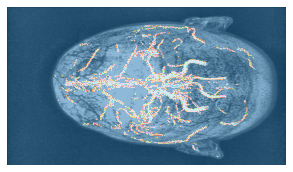

In [13]:
img = PILImage.create(fnames[0])
mask = PILMask.create(str(fnames[0]).replace('images','masks'))
#mask = PILMask.create(str(fnames[0]).replace('mipimages','mipmasks'))
ax = img.show()
ax = mask.show(ctx=ax)

### Load Data

In [14]:
from fastai.vision.all import *
#hide
from fastbook import *

In [15]:
#path = Path("../data/usq/train/images")
#path = Path("../data/usq/imageprojections/all/images")
path = Path("../data/usq/imageprojections/p9/images")
fnames = get_image_files(path)

In [16]:
def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [17]:
codes = ['Background', 'CV']

In [18]:
def get_y(o):
    return get_msk(o)

In [64]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   )

In [32]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   #item_tfms=Resize(224),
                   item_tfms=Resize(634, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [33]:
dsets = dblock.datasets(path)

In [34]:
#dls = dblock.dataloaders(path, bs=4)
dls = dblock.dataloaders(path, bs=8)
dls.vocab = codes

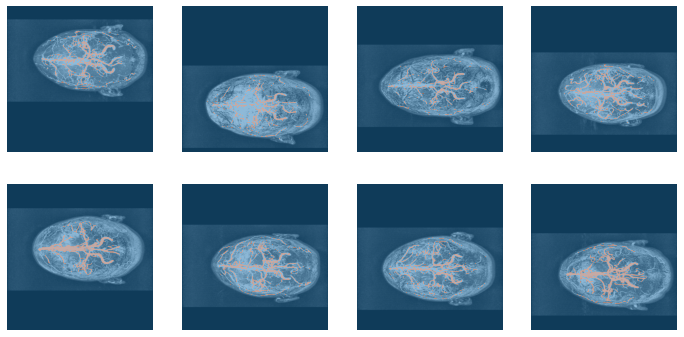

In [35]:
dls.show_batch()

In [29]:
dls.after_item

Pipeline: AddMaskCodes -> Resize -- {'size': (634, 634), 'method': 'pad', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [68]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 81 items
2 datasets of sizes 65,16
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/usq/imageprojections/all/images/MNI_0591_3.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=320x247
  Pipeline: get_y -> PILBase.create
    starting from
      ../data/usq/imageprojections/all/images/MNI_0591_3.jpg
    applying get_y gives
      PILMask mode=L size=320x247
    applying PILBase.create gives
      PILMask mode=L size=320x247

Final sample: (PILImage mode=RGB size=320x247, PILMask mode=L size=320x247)


Found 81 items
2 datasets of sizes 65,16
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline

## Modelling

### Dense U-Net

In [36]:
import sys
sys.path.append('/home/msadmin/notebooks/msc8001/src')
from dense_unet import *
from fastai import *

2021-11-20 05:00:39,489 util_log.py[147] INFO Start the program at:msdsvm, 10.0.0.4, with:Load module


Adjust wk folder for notebook failed


In [40]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
#unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
#                     self_attention=False, y_range=None, norm_type=NormType,
#                     last_cross=True,
#                     bottle=False)
unet = DynamicUnet(encoder, n_classes=2, img_size=(566, 566), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
#print(unet(torch.rand(1,3,224,224)).shape)

    sn        layer     c    w    h               size
2    2         ReLU    64  283  283  (1, 64, 283, 283)
8    8  _DenseBlock  1024   35   35  (1, 1024, 35, 35)
11  11  BatchNorm2d  1024   17   17  (1, 1024, 17, 17)


In [41]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [42]:
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, Dice()])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,foreground_acc,dice,time


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 15.78 GiB total capacity; 7.80 GiB already allocated; 2.50 MiB free; 7.99 GiB reserved in total by PyTorch)

In [63]:
learn.summary()

NameError: name 'learn' is not defined

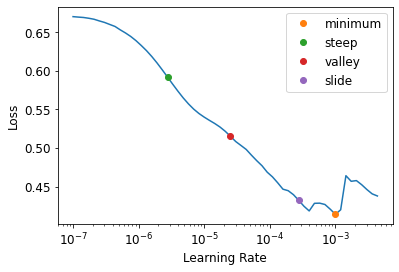

In [59]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [31]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 5.25e-04, steepest point: 3.31e-06


In [32]:
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc])
learn.fit_one_cycle(12, lr_max=slice(lrs.minimum, lrs.steep))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.366054,0.358085,0.000000,00:01
1,0.365272,0.365133,0.000000,00:01
2,0.361963,0.359683,0.000000,00:01
3,0.355343,0.348994,0.000000,00:01
4,0.346430,0.338256,0.000000,00:01
5,0.336639,0.327560,0.000000,00:01
6,0.326979,0.318105,0.000000,00:01
7,0.318083,0.310147,0.000000,00:01
8,0.310248,0.303723,0.000000,00:01
9,0.303516,0.298765,0.000000,00:01


### Weighted Cross Entropy Loss Function

In [16]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [17]:
weights = torch.tensor([[0.5] + [1.5]]).cuda()
weights

tensor([[0.5000, 1.5000]], device='cuda:0')

In [18]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [19]:
# use customer weighted loss function
learn = Learner(dls, unet, loss_func=loss_func, metrics=[foreground_acc, Dice()])
learn.summary()

DynamicUnet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 128 x 56 x 56   
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 32 x 56 x 56    
Conv2d                                    36864    

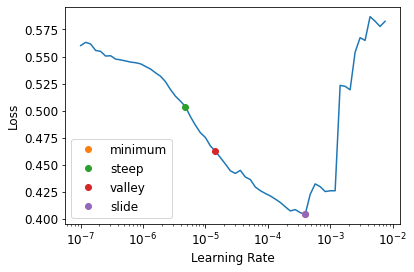

In [20]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [21]:
learn.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.247918,0.225522,0.797665,0.568474,03:53
1,0.200032,0.208256,0.898054,0.586285,03:53
2,0.181215,0.181721,0.785221,0.643713,03:52


In [22]:
learn.unfreeze()

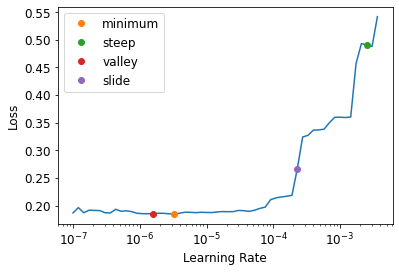

In [23]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [96]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 5.25e-04, steepest point: 1.32e-06


In [24]:
learn.fit_one_cycle(12, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.188177,0.189118,0.836050,0.623803,03:50
1,0.174715,0.149846,0.844660,0.697729,03:50
2,0.134959,0.121673,0.864805,0.762812,03:50
3,0.103074,0.097415,0.914555,0.811774,03:51
4,0.083476,0.078069,0.961627,0.845424,03:51
5,0.072334,0.070333,0.975214,0.856602,03:50
6,0.066607,0.067409,0.964734,0.866643,03:51
7,0.059714,0.067442,0.987239,0.863966,03:51
8,0.058563,0.061908,0.988485,0.865543,03:51
9,0.056327,0.061356,0.992459,0.864622,03:50


In [28]:
learn.fit_one_cycle(12, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.054282,0.061296,0.984484,0.867492,04:04
1,0.059050,0.062730,0.978354,0.867688,03:49
2,0.062440,0.063925,0.990240,0.862838,03:50
3,0.058543,0.064141,0.991915,0.862762,03:51
4,0.056678,0.066163,0.989026,0.866517,03:51
5,0.059431,0.061805,0.985155,0.866716,03:51
6,0.055822,0.065885,0.994678,0.860670,03:50
7,0.053964,0.059696,0.986998,0.867752,03:50
8,0.052206,0.063210,0.974234,0.869138,03:50
9,0.051064,0.062335,0.985109,0.867822,03:49


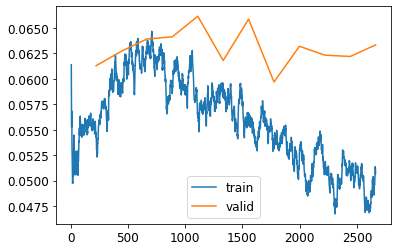

In [29]:
learn.recorder.plot_loss()

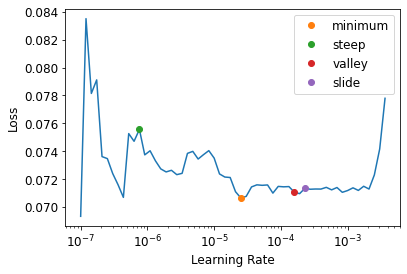

In [46]:
# try dice as loss function
opt = ranger
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, Dice()], opt_func=opt)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#learn.fit_one_cycle(24, lr_max=slice(1e-6,0.00013))

In [47]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.069104,0.070270,0.817296,0.796205,03:50
1,0.067958,0.069394,0.822107,0.799232,03:50
2,0.067885,0.069284,0.823272,0.799678,03:52


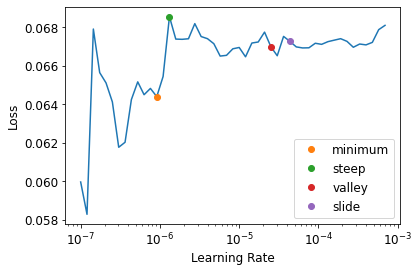

In [48]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [17]:
learn.fit_one_cycle(48, lr_max=slice(1e-6,0.00013))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.118556,0.114985,0.615694,0.655080,07:55
1,0.112288,0.110943,0.616278,0.661270,07:55
2,0.106062,0.103195,0.625149,0.676979,07:56
3,0.095836,0.092407,0.645908,0.702038,07:56
4,0.081122,0.081511,0.838801,0.774944,07:56
5,0.070743,0.069843,0.751617,0.776966,07:56
6,0.064638,0.063234,0.866156,0.820113,07:55
7,0.061951,0.058609,0.866312,0.833344,07:57
8,0.059048,0.055486,0.899142,0.845620,07:57
9,0.054147,0.054517,0.924820,0.850305,07:56


## Results

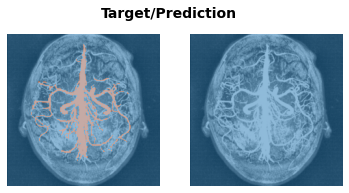

In [17]:
learn.show_results()

In [62]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

NameError: name 'learn' is not defined

### Save model

In [27]:
learn.export('dense_unet_model.pkl')

In [32]:
## Measure

In [19]:
dl = learn.dls.test_dl(fnames[:5])

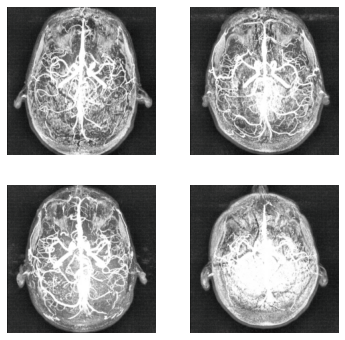

In [20]:
dl.show_batch()

In [21]:
preds = learn.get_preds(dl=dl)

In [22]:
preds[0].shape

torch.Size([5, 2, 224, 224])

In [23]:
pred_1 = preds[0][0]

In [24]:
pred_1.shape

torch.Size([2, 224, 224])

In [25]:
pred_arx = pred_1.argmax(dim=0)

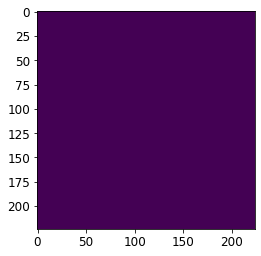

In [26]:
plt.imshow(pred_arx)

In [27]:
pred_arx = pred_arx.numpy()

In [28]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [29]:
im = Image.fromarray(rescaled)

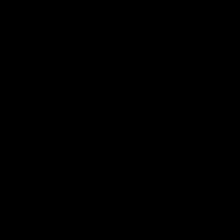

In [30]:
im